In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

In [2]:
# =============================================================================
# 1. CARGA Y PREPROCESAMIENTO DE DATOS
# =============================================================================

# Cargar el dataset
file_path = "smoking.csv"
df = pd.read_csv(file_path)
print("Dataset cargado exitosamente")
print(f"Forma del dataset: {df.shape}")
print(f"Columnas: {df.columns.tolist()}")

# Eliminar columnas que no aportan al clustering
cols_to_drop = ['ID']
df = df.drop(columns=cols_to_drop, errors='ignore')

# Codificar variables categóricas
cat_cols = ['gender', 'oral', 'tartar']
le = LabelEncoder()
for col in cat_cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col])

# Guardar la columna 'smoking' para análisis posterior
y = df['smoking'].copy()
X = df.drop(columns=['smoking'])

# Escalar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Datos procesados: {X_scaled.shape}")

Dataset cargado exitosamente
Forma del dataset: (55692, 27)
Columnas: ['ID', 'gender', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'oral', 'dental caries', 'tartar', 'smoking']
Datos procesados: (55692, 25)


In [3]:
# =============================================================================
# 2. FUNCIONES DE VISUALIZACIÓN (Basadas en el notebook original)
# =============================================================================

def plot_clusters(X, y=None, title=""):
    """Función para graficar clusters en 2D"""
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", s=10, alpha=0.7)
    plt.xlabel("Componente Principal 1", fontsize=12)
    plt.ylabel("Componente Principal 2", fontsize=12)
    if title:
        plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)

def plot_data(X):
    """Graficar datos como puntos negros"""
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2, alpha=0.6)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    """Graficar centroides"""
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=150, linewidths=3,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=3,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=300, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    """Graficar fronteras de decisión"""
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2", alpha=0.7)
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k', alpha=0.5)
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("Componente Principal 1", fontsize=12)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("Componente Principal 2", fontsize=12)
    else:
        plt.tick_params(labelleft=False)

<ipython-input-3-c1f06fd11932>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", s=10, alpha=0.7)


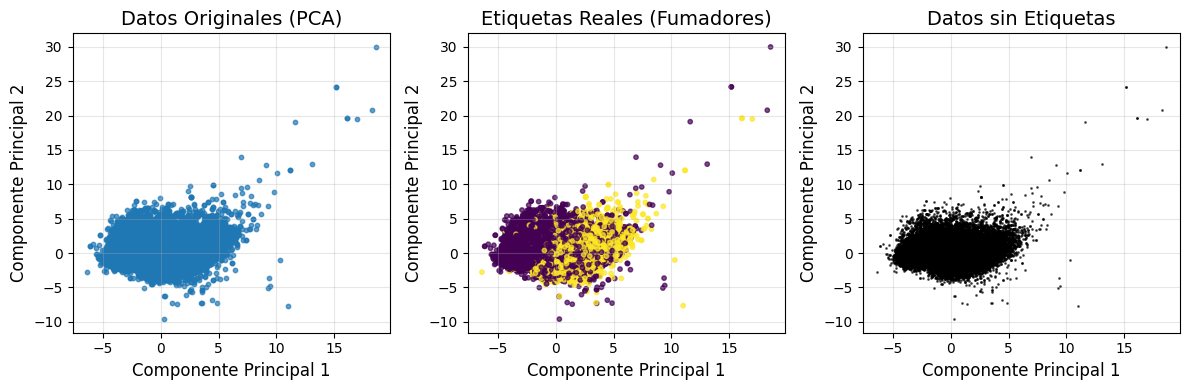

Analizando diferentes números de clusters...


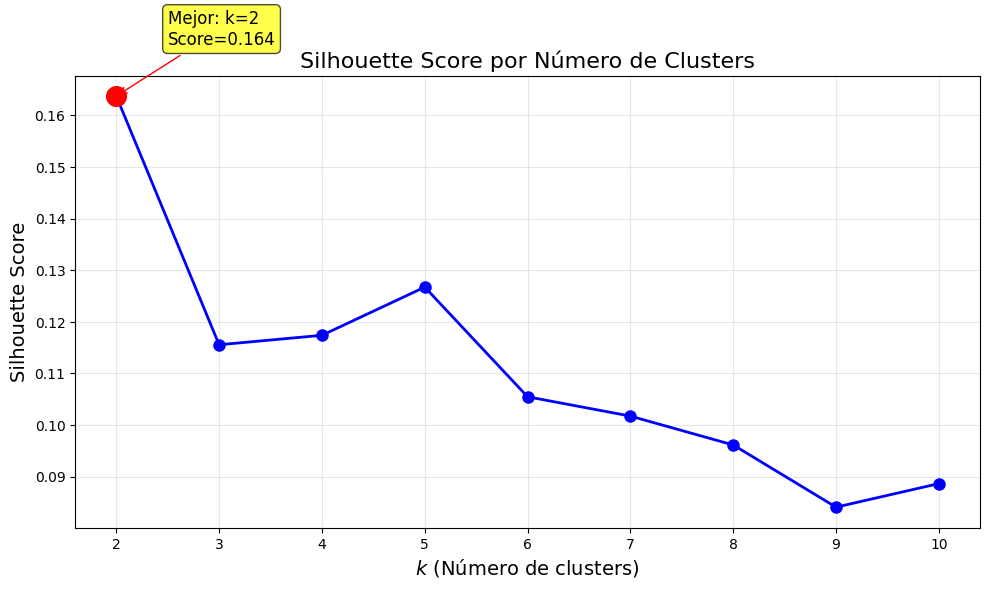

Mejor número de clusters: k = 2
Mejor Silhouette Score: 0.164


In [4]:
# =============================================================================
# 3. VISUALIZACIÓN INICIAL DE LOS DATOS
# =============================================================================

plt.figure(figsize=(12, 4))

# Datos originales
plt.subplot(131)
plot_clusters(X_pca, title="Datos Originales (PCA)")

# Con etiquetas reales de fumadores
plt.subplot(132)
plot_clusters(X_pca, y, title="Etiquetas Reales (Fumadores)")

# Solo los datos sin etiquetas
plt.subplot(133)
plot_data(X_pca)
plt.xlabel("Componente Principal 1", fontsize=12)
plt.ylabel("Componente Principal 2", fontsize=12)
plt.title("Datos sin Etiquetas", fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# 4. ANÁLISIS DE SILHOUETTE SCORE (Basado en celda 22 del notebook)
# =============================================================================

print("Analizando diferentes números de clusters...")

# Entrenar modelos con diferentes números de clusters
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_scaled) for k in range(2, 11)]

# Calcular silhouette scores
silhouette_scores = [silhouette_score(X_scaled, model.labels_) for model in kmeans_per_k]

# Graficar silhouette scores (Estilo del notebook original)
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, "bo-", linewidth=2, markersize=8)
plt.xlabel("$k$ (Número de clusters)", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.title("Silhouette Score por Número de Clusters", fontsize=16)
plt.grid(True, alpha=0.3)

# Marcar el mejor score
best_k = range(2, 11)[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
plt.scatter(best_k, best_score, color='red', s=200, zorder=5)
plt.annotate(f'Mejor: k={best_k}\nScore={best_score:.3f}',
             xy=(best_k, best_score),
             xytext=(best_k+0.5, best_score+0.01),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=12, ha='left',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()

print(f"Mejor número de clusters: k = {best_k}")
print(f"Mejor Silhouette Score: {best_score:.3f}")

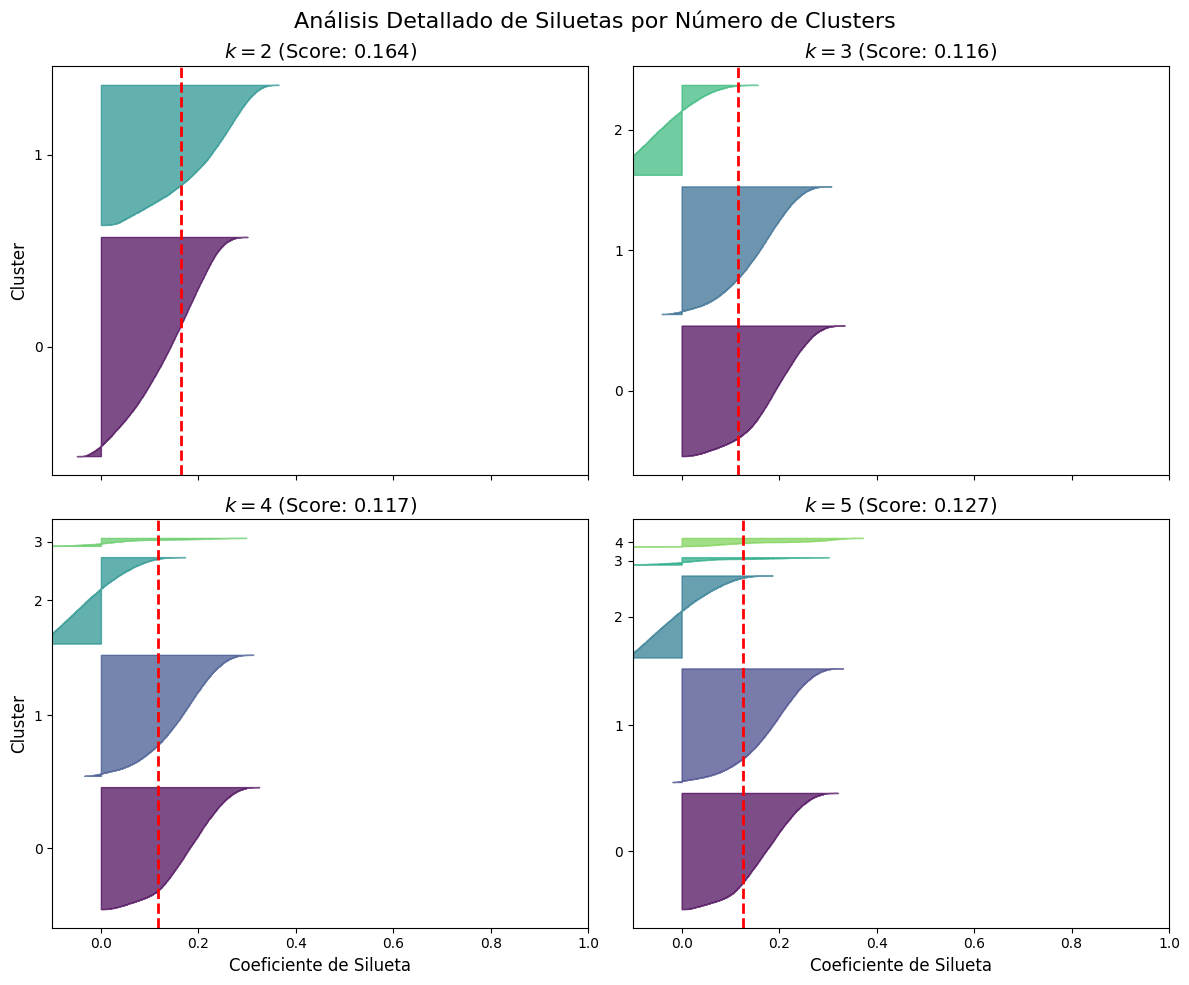

In [5]:
# =============================================================================
# 5. VISUALIZACIÓN DETALLADA DE SILUETAS
# =============================================================================

plt.figure(figsize=(12, 10))

# Analizar k desde 2 hasta 5
for i, k in enumerate([2, 3, 4, 5]):
    plt.subplot(2, 2, i + 1)

    y_pred = kmeans_per_k[k - 2].labels_
    silhouette_coefficients = silhouette_samples(X_scaled, y_pred)

    padding = len(X_scaled) // 30
    pos = padding
    ticks = []

    for cluster_id in range(k):
        coeffs = silhouette_coefficients[y_pred == cluster_id]
        coeffs.sort()

        color = mpl.cm.viridis(cluster_id / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

    if i in [0, 2]:  # Lado izquierdo
        plt.ylabel("Cluster", fontsize=12)

    if i in [2, 3]:  # Fila inferior
        plt.xlabel("Coeficiente de Silueta", fontsize=12)
    else:
        plt.tick_params(labelbottom=False)

    # Línea del score promedio
    avg_score = silhouette_scores[k - 2]
    plt.axvline(x=avg_score, color="red", linestyle="--", linewidth=2)
    plt.title(f"$k={k}$ (Score: {avg_score:.3f})", fontsize=14)

    # Ajustar límites del eje x
    plt.xlim([-0.1, 1])

plt.suptitle("Análisis Detallado de Siluetas por Número de Clusters", fontsize=16)
plt.tight_layout()
plt.show()

ValueError: X has 2 features, but KMeans is expecting 25 features as input.

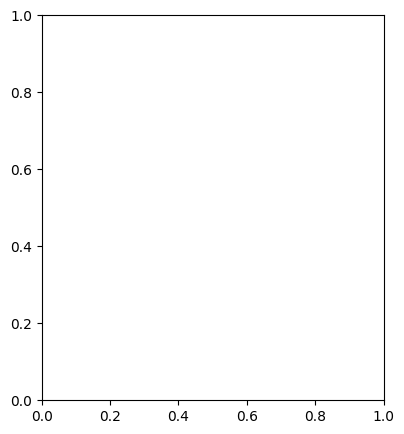

In [6]:
# =============================================================================
# 6. CLUSTERING FINAL CON K ÓPTIMO
# =============================================================================

# Usar el mejor k encontrado
optimal_kmeans = KMeans(n_clusters=best_k, random_state=42)
optimal_clusters = optimal_kmeans.fit_predict(X_scaled)

plt.figure(figsize=(15, 5))

# Clustering con k óptimo
plt.subplot(131)
plot_decision_boundaries(optimal_kmeans, X_pca)
plt.title(f"Clustering Óptimo (k={best_k})", fontsize=14)

# Comparación con etiquetas reales
plt.subplot(132)
plot_clusters(X_pca, y, title="Etiquetas Reales (Fumadores)")

# Comparación lado a lado
plt.subplot(133)
plot_clusters(X_pca, optimal_clusters, title=f"Clusters Predichos (k={best_k})")

plt.tight_layout()
plt.show()

In [7]:
# =============================================================================
# 7. ANÁLISIS DE RESULTADOS
# =============================================================================

print("="*50)
print("ANÁLISIS DE RESULTADOS")
print("="*50)

# Comparar clustering con etiquetas reales
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(y, optimal_clusters)
nmi = normalized_mutual_info_score(y, optimal_clusters)

print(f"Número óptimo de clusters: {best_k}")
print(f"Silhouette Score óptimo: {best_score:.3f}")
print(f"Adjusted Rand Index vs etiquetas reales: {ari:.3f}")
print(f"Normalized Mutual Information vs etiquetas reales: {nmi:.3f}")

# Análisis por cluster
print(f"\nDistribución de clusters:")
unique, counts = np.unique(optimal_clusters, return_counts=True)
for cluster_id, count in zip(unique, counts):
    percentage = (count / len(optimal_clusters)) * 100
    print(f"Cluster {cluster_id}: {count} muestras ({percentage:.1f}%)")

# Análisis de fumadores por cluster
print(f"\nAnálisis de fumadores por cluster:")
for cluster_id in unique:
    cluster_mask = optimal_clusters == cluster_id
    smokers_in_cluster = y[cluster_mask].sum()
    total_in_cluster = cluster_mask.sum()
    smoker_percentage = (smokers_in_cluster / total_in_cluster) * 100
    print(f"Cluster {cluster_id}: {smokers_in_cluster}/{total_in_cluster} fumadores ({smoker_percentage:.1f}%)")

ANÁLISIS DE RESULTADOS
Número óptimo de clusters: 2
Silhouette Score óptimo: 0.164
Adjusted Rand Index vs etiquetas reales: 0.148
Normalized Mutual Information vs etiquetas reales: 0.193

Distribución de clusters:
Cluster 0: 33973 muestras (61.0%)
Cluster 1: 21719 muestras (39.0%)

Análisis de fumadores por cluster:
Cluster 0: 18699/33973 fumadores (55.0%)
Cluster 1: 1756/21719 fumadores (8.1%)
